
Trading Pair: BTC/USDT
Sell target: 1.5%
Stop Loss: 50.0%
Martingale Multiples: 1
Martingale Buy: 0.85%
max bets: 20
Initial Buy: RSI(14) < 40.0 (or SMA5 > SMA10 and RSI < 40.0 after stop loss)
Interval: 3m

Time Period: 2025-12-01 to 2026-01-21
Initial Capital: 400.00 USDT
Final NAV: 421.55 USDT
Total Profit/Loss: 21.55 USDT
Percentage of Return (Strategy): 5.39%
Percentage of Return (Asset, Original): -0.63%
Return on Assets (Profit / (Longest Cycle Buys * Single Bet Size)): 10.77%
Maximum Drawdown: 1.85%
Sharpe Ratio (Annualized): 4.71
Number of Buy Trades: 88
Number of Sell Trades: 23
Number of Stop Loss Trades: 0

Longest Martingale Cycle (by Number of Buys):
Start: 2025-12-11 22:45:00
End: 2025-12-17 15:27:00
Duration: 136.70 hours
Number of Buys: 10

Statistics for Martingale Cycles with Maximum Buy Counts (10 buys):
Number of Such Cycles: 1
Average Duration: 136.70 hours
Total Profit/Loss from These Cycles: 2.85 USDT


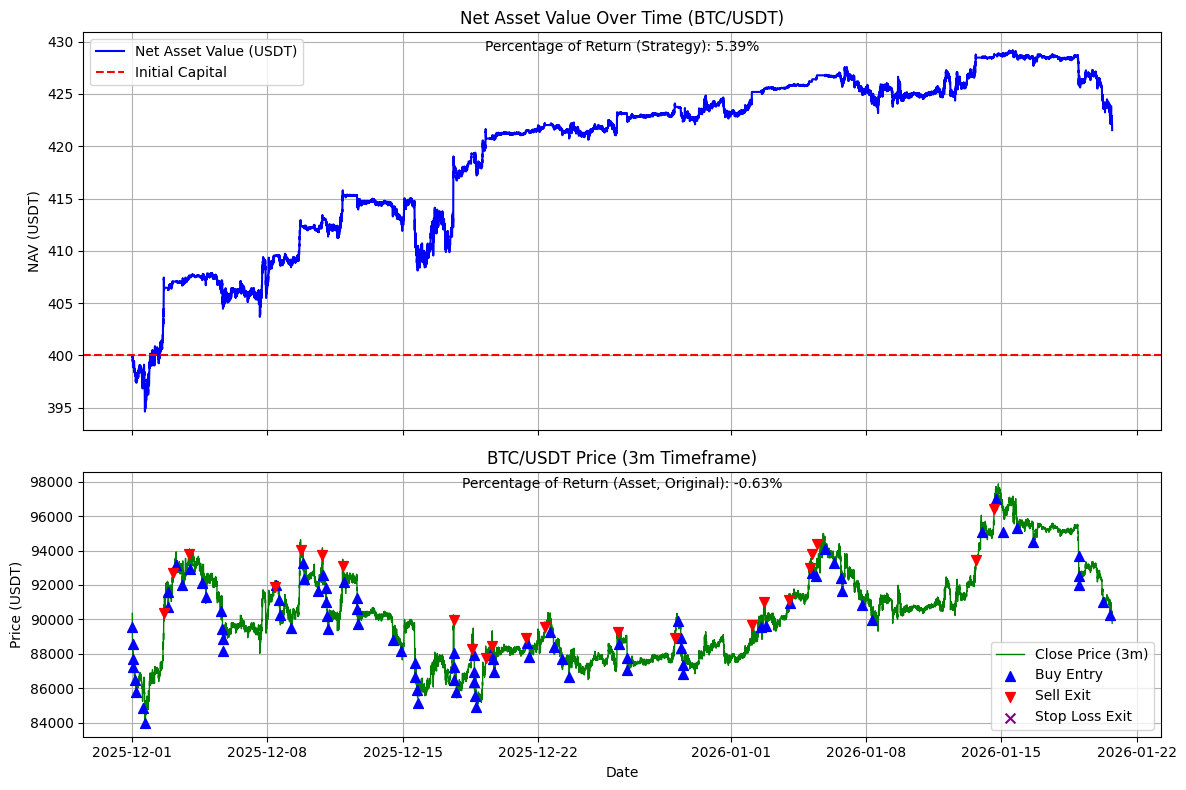

In [5]:
## 05/02 with annotations Great！data source changed to binandeus insteade of binance
# 1.2/0.9 35.6% 01/01/25-08/06/25
# 1.5/0.85 38.62% 

import ccxt
import pandas as pd
import numpy as np
from ta.momentum import RSIIndicator
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Configuration Variables
single_bet_size = 20.0  # USDT per bet
martingale_multiples = 1  # Multiples of single_bet_size for Martingale buys
max_bets = 20  # Maximum number of bets
rsi_threshold = 40.0  # RSI(14) threshold for initial entry
profit_target = 1.5  # Sell if position gains 1.67% and price breaks below EMA
martingale_price_drop = 0.85  # Percentage drop from first entry price for Martingale buys
stop_loss_percentage =50.0  # Stop loss as percentage drop from initial buy-in price
trading_fee_percentage = 0.08  # Trading fee as a percentage (0.08% per trade)
ema_period = 11  # Period for the short-term EMA
sma_short_period = 5  # Period for short-term SMA
sma_long_period = 10  # Period for long-term SMA
symbol = 'BTC/USDT'  # Trading pair
timeframe = '3m'  # Input timeframe (can be 1m, 3m, 5m, 15m, 30m, 1h, 2h, 4h, 6h, 8h, 12h, 1d, 3d, 1w, 1M)
backtest_start_date = '2025-12-01'  # Backtest start date
backtest_end_date = '2026-01-21'  # Backtest end date
lookback_candles = 300  # Number of candles prior to backtest_start_date for indicators

# Initialize exchange
exchange = ccxt.binanceus()

# Function to convert timeframe to milliseconds per candle
def timeframe_to_ms(tf):
    tf = tf.lower()
    if 'm' in tf:  # Minutes
        minutes = int(tf.replace('m', ''))
        return minutes * 60 * 1000
    elif 'h' in tf:  # Hours
        hours = int(tf.replace('h', ''))
        return hours * 60 * 60 * 1000
    elif 'd' in tf:  # Days
        days = int(tf.replace('d', ''))
        return days * 24 * 60 * 60 * 1000
    elif 'w' in tf:  # Weeks
        weeks = int(tf.replace('w', ''))
        return weeks * 7 * 24 * 60 * 60 * 1000
    elif 'M' in tf:  # Months (approximated as 30 days)
        months = int(tf.replace('M', ''))
        return months * 30 * 24 * 60 * 60 * 1000
    else:
        raise ValueError(f"Unsupported timeframe: {tf}")

# Validate timeframe
supported_timeframes = ['1m', '3m', '5m', '15m', '30m', '1h', '2h', '4h', '6h', '8h', '12h', '1d', '3d', '1w', '1M']
if timeframe not in supported_timeframes:
    raise ValueError(f"Timeframe {timeframe} is not supported by Binance. Supported timeframes: {supported_timeframes}")

# Convert dates to timestamps
backtest_start_ts = int(datetime.strptime(backtest_start_date, '%Y-%m-%d').timestamp() * 1000)
backtest_end_ts = int(datetime.strptime(backtest_end_date, '%Y-%m-%d').timestamp() * 1000)

# Calculate fetch start timestamp based on lookback_candles and timeframe
candle_duration_ms = timeframe_to_ms(timeframe)
fetch_start_ts = backtest_start_ts - (lookback_candles * candle_duration_ms)

# Fetch historical OHLCV data at the specified timeframe
all_ohlcv = []
start_ts = fetch_start_ts
while start_ts < backtest_end_ts:
    ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since=start_ts, limit=1000)
    if not ohlcv:
        break
    all_ohlcv.extend(ohlcv)
    start_ts = ohlcv[-1][0] + 1
    if start_ts >= backtest_end_ts:
        break

# Convert to DataFrame
df = pd.DataFrame(all_ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df.set_index('timestamp', inplace=True)

# Calculate RSI(14), EMA(11), SMA(5), and SMA(10)
df['rsi'] = RSIIndicator(df['close'], window=14).rsi()
df['ema_11'] = df['close'].ewm(span=ema_period, adjust=False).mean()
df['sma_5'] = df['close'].rolling(window=sma_short_period).mean()
df['sma_10'] = df['close'].rolling(window=sma_long_period).mean()

# Filter data to backtest period
df_backtest = df[(df.index >= pd.to_datetime(backtest_start_date)) & 
                 (df.index <= pd.to_datetime(backtest_end_date))].copy()

# Check if backtest DataFrame is empty
if df_backtest.empty:
    raise ValueError(f"No data available for the backtest period {backtest_start_date} to {backtest_end_date}.")

# Calculate asset return (original)
initial_price = df_backtest['close'].iloc[0]
final_price = df_backtest['close'].iloc[-1]
asset_percentage_return = (final_price - initial_price) / initial_price * 100

# Initialize trading variables
positions = []  # [entry_price, amount_btc]
trades = []  # [timestamp, type, price, amount_btc, usdt_value, total_btc, total_usdt_cost, nav]
total_btc = 0.0
total_usdt_cost = 0.0
nav_history = []  # [timestamp, nav]
initial_capital = single_bet_size * max_bets
cash = initial_capital
cumulative_nav = initial_capital
first_entry_price = 0.0
profit_target_reached = False
stop_loss_triggered = False  # Flag to track if stop loss was triggered
cycle_start_time = None  # Track start of Martingale cycle
cycle_buy_count = 0  # Track number of buys in current cycle
cycles = []  # Store [start_time, end_time, duration, buy_count, cycle_profit_loss]

# Trading logic
for i in range(1, len(df_backtest)):
    low_price = df_backtest['low'].iloc[i]
    high_price = df_backtest['high'].iloc[i]
    close_price = df_backtest['close'].iloc[i]
    timestamp = df_backtest.index[i]
    rsi = df_backtest['rsi'].iloc[i]
    ema_11 = df_backtest['ema_11'].iloc[i]
    sma_5 = df_backtest['sma_5'].iloc[i]
    sma_10 = df_backtest['sma_10'].iloc[i]

    # Check for stop loss condition
    if len(positions) > 0 and first_entry_price > 0:
        price_drop_percentage = (first_entry_price - low_price) / first_entry_price * 100
        if price_drop_percentage >= stop_loss_percentage:
            usdt_received = total_btc * high_price  # Sell at high price
            fee = usdt_received * (trading_fee_percentage / 100)
            usdt_received -= fee
            cash += usdt_received
            cumulative_nav = cash
            trades.append([timestamp, 'STOP_LOSS_SELL', high_price, total_btc, usdt_received, 0.0, 0.0, cumulative_nav])
            nav_history.append([timestamp, cumulative_nav])
            # Record cycle duration, buy count, and profit/loss
            if cycle_start_time is not None:
                cycle_duration = (timestamp - cycle_start_time).total_seconds() / 3600  # Duration in hours
                # Calculate cycle profit/loss
                cycle_trades = [trade for trade in trades if trade[0] >= cycle_start_time and trade[0] <= timestamp]
                cycle_profit_loss = sum(trade[4] if trade[1] in ['SELL', 'STOP_LOSS_SELL'] else -trade[4] for trade in cycle_trades)
                cycles.append([cycle_start_time, timestamp, cycle_duration, cycle_buy_count, cycle_profit_loss])
                cycle_start_time = None
                cycle_buy_count = 0
            positions = []
            total_btc = 0.0
            total_usdt_cost = 0.0
            first_entry_price = 0.0
            profit_target_reached = False
            stop_loss_triggered = True
            continue

    # Initial buy condition
    can_buy = False
    if stop_loss_triggered:
        # After stop loss, require SMA5 > SMA10 and RSI < threshold
        if pd.notna(sma_5) and pd.notna(sma_10) and sma_5 > sma_10 and rsi < rsi_threshold:
            can_buy = True
    else:
        # Normal case, only RSI < threshold
        if rsi < rsi_threshold:
            can_buy = True

    if len(positions) == 0 and can_buy and cash >= single_bet_size:
        fee = single_bet_size * (trading_fee_percentage / 100)
        usdt_after_fee = single_bet_size - fee
        amount_btc = usdt_after_fee / low_price
        positions.append([low_price, amount_btc])
        total_btc += amount_btc
        total_usdt_cost += single_bet_size
        cash -= single_bet_size
        first_entry_price = low_price
        profit_target_reached = False
        stop_loss_triggered = False  # Reset stop loss flag after new buy
        cycle_start_time = timestamp  # Start new cycle
        cycle_buy_count = 1  # Count initial buy
        cumulative_nav = cash + (total_btc * close_price)
        trades.append([timestamp, 'BUY', low_price, amount_btc, single_bet_size, total_btc, total_usdt_cost, cumulative_nav])
        nav_history.append([timestamp, cumulative_nav])

    # Martingale buy condition
    elif len(positions) > 0 and len(positions) < max_bets:
        price_drop = first_entry_price * (martingale_price_drop / 100)
        target_price = first_entry_price - (price_drop * len(positions))
        martingale_bet_size = single_bet_size * martingale_multiples
        if low_price <= target_price and cash >= martingale_bet_size:
            fee = martingale_bet_size * (trading_fee_percentage / 100)
            usdt_after_fee = martingale_bet_size - fee
            amount_btc = usdt_after_fee / low_price
            positions.append([low_price, amount_btc])
            total_btc += amount_btc
            total_usdt_cost += martingale_bet_size
            cash -= martingale_bet_size
            cycle_buy_count += 1  # Increment buy count for cycle
            cumulative_nav = cash + (total_btc * close_price)
            trades.append([timestamp, 'BUY', low_price, amount_btc, martingale_bet_size, total_btc, total_usdt_cost, cumulative_nav])
            nav_history.append([timestamp, cumulative_nav])

    # Sell condition
    if len(positions) > 0:
        current_value = total_btc * high_price
        profit_percentage = (current_value - total_usdt_cost) / total_usdt_cost * 100

        if profit_percentage >= profit_target:
            profit_target_reached = True

        if profit_target_reached and close_price < ema_11 and profit_percentage > 0:
            usdt_received = total_btc * high_price
            fee = usdt_received * (trading_fee_percentage / 100)
            usdt_received -= fee
            cash += usdt_received
            cumulative_nav = cash
            trades.append([timestamp, 'SELL', high_price, total_btc, usdt_received, 0.0, 0.0, cumulative_nav])
            nav_history.append([timestamp, cumulative_nav])
            # Record cycle duration, buy count, and profit/loss
            if cycle_start_time is not None:
                cycle_duration = (timestamp - cycle_start_time).total_seconds() / 3600  # Duration in hours
                # Calculate cycle profit/loss
                cycle_trades = [trade for trade in trades if trade[0] >= cycle_start_time and trade[0] <= timestamp]
                cycle_profit_loss = sum(trade[4] if trade[1] in ['SELL', 'STOP_LOSS_SELL'] else -trade[4] for trade in cycle_trades)
                cycles.append([cycle_start_time, timestamp, cycle_duration, cycle_buy_count, cycle_profit_loss])
                cycle_start_time = None
                cycle_buy_count = 0
            positions = []
            total_btc = 0.0
            total_usdt_cost = 0.0
            first_entry_price = 0.0
            profit_target_reached = False
            stop_loss_triggered = False

    # Update NAV if no trade
    if len(trades) == 0 or trades[-1][0] != timestamp:
        cumulative_nav = cash + (total_btc * close_price) if total_btc > 0 else cash
        nav_history.append([timestamp, cumulative_nav])

# Convert trades to DataFrame
trades_df = pd.DataFrame(trades, columns=['Timestamp', 'Type', 'Price', 'Amount_BTC', 'USDT_Value', 'Total_BTC', 'Total_USDT_Cost', 'NAV'])

# Calculate total profit/loss
final_nav = nav_history[-1][1]
total_profit_loss = final_nav - initial_capital

# Calculate strategy return
strategy_percentage_return = (total_profit_loss / initial_capital) * 100

# Calculate Maximum Drawdown
nav_values = [nav[1] for nav in nav_history]
peak = nav_values[0]
max_drawdown_percentage = 0.0
for nav in nav_values:
    if nav > peak:
        peak = nav
    drawdown = (peak - nav) / peak * 100
    if drawdown > max_drawdown_percentage:
        max_drawdown_percentage = drawdown

# Calculate Sharpe Ratio
nav_df = pd.DataFrame(nav_history, columns=['Timestamp', 'NAV'])
nav_df.set_index('Timestamp', inplace=True)
daily_nav = nav_df['NAV'].resample('D').last().ffill()
daily_returns = daily_nav.pct_change().dropna()
mean_daily_return = daily_returns.mean()
std_daily_return = daily_returns.std()
sharpe_ratio = (mean_daily_return / std_daily_return) * np.sqrt(365) if std_daily_return != 0 else 0.0

# Calculate number of trades
num_buy_trades = len(trades_df[trades_df['Type'] == 'BUY'])
num_sell_trades = len(trades_df[trades_df['Type'] == 'SELL'])
num_stop_loss_trades = len(trades_df[trades_df['Type'] == 'STOP_LOSS_SELL'])

# Find the longest Martingale cycle (by number of buys) and its buy count
longest_cycle = None
if cycles:
    longest_cycle = max(cycles, key=lambda x: x[3])  # Max by buy_count
    longest_cycle_start = longest_cycle[0]
    longest_cycle_end = longest_cycle[1]
    longest_cycle_duration = longest_cycle[2]
    longest_cycle_buy_count = longest_cycle[3]
else:
    longest_cycle_start = "N/A"
    longest_cycle_end = "N/A"
    longest_cycle_duration = 0.0
    longest_cycle_buy_count = 0

# Statistics for cycles with maximum buy counts
max_buy_cycles = [cycle for cycle in cycles if cycle[3] == longest_cycle_buy_count]
num_max_buy_cycles = len(max_buy_cycles)
avg_max_buy_cycle_duration = np.mean([cycle[2] for cycle in max_buy_cycles]) if max_buy_cycles else 0.0
total_max_buy_cycle_profit_loss = sum(cycle[4] for cycle in max_buy_cycles) if max_buy_cycles else 0.0

# Calculate Return on Assets (ROA)
if longest_cycle_buy_count > 0:
    roa_denominator = longest_cycle_buy_count * single_bet_size
    roa_percentage = (total_profit_loss / roa_denominator) * 100 if roa_denominator != 0 else 0.0
else:
    roa_percentage = 0.0


# Print trades
# print("\nAll Trades:")
# print(trades_df.to_string(index=False))

# Print summary
print(f"\nTrading Pair: {symbol}")
print(f"Sell target: {profit_target}%")
print(f"Stop Loss: {stop_loss_percentage}%")
print(f"Martingale Multiples: {martingale_multiples}")
print(f"Martingale Buy: {martingale_price_drop}%")
print(f"max bets: {max_bets}")
print(f"Initial Buy: RSI(14) < {rsi_threshold} (or SMA{sma_short_period} > SMA{sma_long_period} and RSI < {rsi_threshold} after stop loss)")
print(f"Interval: {timeframe}")
print(f"\nTime Period: {backtest_start_date} to {backtest_end_date}")
print(f"Initial Capital: {initial_capital:.2f} USDT")
print(f"Final NAV: {final_nav:.2f} USDT")
print(f"Total Profit/Loss: {total_profit_loss:.2f} USDT")
print(f"Percentage of Return (Strategy): {strategy_percentage_return:.2f}%")
print(f"Percentage of Return (Asset, Original): {asset_percentage_return:.2f}%")
print(f"Return on Assets (Profit / (Longest Cycle Buys * Single Bet Size)): {roa_percentage:.2f}%")
print(f"Maximum Drawdown: {max_drawdown_percentage:.2f}%")
print(f"Sharpe Ratio (Annualized): {sharpe_ratio:.2f}")
print(f"Number of Buy Trades: {num_buy_trades}")
print(f"Number of Sell Trades: {num_sell_trades}")
print(f"Number of Stop Loss Trades: {num_stop_loss_trades}")
print(f"\nLongest Martingale Cycle (by Number of Buys):")
print(f"Start: {longest_cycle_start}")
print(f"End: {longest_cycle_end}")
print(f"Duration: {longest_cycle_duration:.2f} hours")
print(f"Number of Buys: {longest_cycle_buy_count}")
print(f"\nStatistics for Martingale Cycles with Maximum Buy Counts ({longest_cycle_buy_count} buys):")
print(f"Number of Such Cycles: {num_max_buy_cycles}")
print(f"Average Duration: {avg_max_buy_cycle_duration:.2f} hours")
print(f"Total Profit/Loss from These Cycles: {total_max_buy_cycle_profit_loss:.2f} USDT")

# Plot NAV and price in two separate subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [3, 2]})

# Plot NAV in the first subplot
nav_df = pd.DataFrame(nav_history, columns=['Timestamp', 'NAV'])
ax1.plot(nav_df['Timestamp'], nav_df['NAV'], label='Net Asset Value (USDT)', color='blue')
ax1.axhline(y=initial_capital, color='r', linestyle='--', label='Initial Capital')
ax1.set_title(f'Net Asset Value Over Time ({symbol})')
ax1.set_ylabel('NAV (USDT)')
ax1.legend()
ax1.grid(True)
# Add annotation for Strategy Percentage Return at top center
ax1.text(0.5, 0.98, f'Percentage of Return (Strategy): {strategy_percentage_return:.2f}%', 
         transform=ax1.transAxes, fontsize=10, horizontalalignment='center', verticalalignment='top')

# Plot BTC/USDT price in the second subplot
ax2.plot(df_backtest.index, df_backtest['close'], label=f'Close Price ({timeframe})', color='green', linewidth=1)
ax2.set_title(f'{symbol} Price ({timeframe} Timeframe)')
ax2.set_xlabel('Date')
ax2.set_ylabel('Price (USDT)')

# Add annotations for BUY, SELL, and STOP_LOSS_SELL trades
buy_trades = trades_df[trades_df['Type'] == 'BUY']
sell_trades = trades_df[trades_df['Type'] == 'SELL']
stop_loss_trades = trades_df[trades_df['Type'] == 'STOP_LOSS_SELL']

# Use scatter plot for distinct points
ax2.scatter(buy_trades['Timestamp'], buy_trades['Price'], color='blue', marker='^', zorder=5, label='Buy Entry', s=50)
ax2.scatter(sell_trades['Timestamp'], sell_trades['Price'], color='red', marker='v', zorder=5, label='Sell Exit', s=50)
ax2.scatter(stop_loss_trades['Timestamp'], stop_loss_trades['Price'], color='purple', marker='x', zorder=5, label='Stop Loss Exit', s=50)

ax2.legend()
ax2.grid(True)
# Add annotation for Asset Percentage Return at top center
ax2.text(0.5, 0.98, f'Percentage of Return (Asset, Original): {asset_percentage_return:.2f}%', 
         transform=ax2.transAxes, fontsize=10, horizontalalignment='center', verticalalignment='top')

# Adjust layout and save the plot
plt.tight_layout()
plt.savefig('crypto_trading_results.png')
plt.show()